In [1]:
%matplotlib inline
import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf

code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffLikelihood

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [38]:


svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf



NameError: name 'time' is not defined

In [4]:
just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [6]:
just_grid

,grid_squar,geometry,lat,lon
4860,25017333300,"POLYGON ((-71.16139 42.47071, -71.16136 42.471...",42.470764,-71.152055
4861,25017333400,"POLYGON ((-71.14690 42.48077, -71.14673 42.480...",42.484548,-71.132032
4862,25017333502,"POLYGON ((-71.15960 42.48482, -71.15954 42.484...",42.485040,-71.146119
4863,25017354500,"POLYGON ((-71.13077 42.38261, -71.13070 42.382...",42.384745,-71.125040
4864,25017354700,"POLYGON ((-71.12901 42.39007, -71.12768 42.389...",42.389581,-71.122629
...,...,...,...,...
6475,25009208302,"POLYGON ((-71.01723 42.48901, -71.01705 42.489...",42.485038,-71.004081
6476,25009212101,"POLYGON ((-71.05565 42.62288, -71.05509 42.625...",42.613694,-71.005231
6477,25009208401,"POLYGON ((-71.04695 42.48796, -71.04672 42.488...",42.487612,-71.030763
6478,25009208402,"POLYGON ((-71.05389 42.47878, -71.05373 42.479...",42.466251,-71.035971


In [7]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [8]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()

In [9]:
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()

In [10]:
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)

In [11]:
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [12]:
deaths_gdf.loc[idx[tract,2011,:],:]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25009212102 2011 1            25      009  212102  2121.02   
                 2            25      009  212102  2121.02   
                 3            25      009  212102  2121.02   
                 4            25      009  212102  2121.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25009212102 2011 1        Census Tract 2121.02  G5020        S  14256626   
                 2        Census Tract 2121.02  G5020        S  14256626   
                 3        Census Tract 2121.02  G5020        S  14256626   
                 4        Census Tract 2121.02  G5020        S  14256626   

                           AWATER        lat  ...  theme_3_pc  theme_4_pc  \
grid_squar  year quarter                      ...                           
25009212102 2011 1        2121499  42.600718  ...        0.44       0.736   
                 2        2121499  42.600718  ...        0.44       0.736   
                 3        2121499  42.600718  ...        0.44       0.736   
                 4        2121499  42.600718  ...        0.44       0.736   

                          svi_pctile  FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                        
25009212102 2011 1            0.5171  None      212100      212100       None   
                 2            0.5171  None      212100      212100       None   
                 3            0.5171  None      212100      212100       None   
                 4            0.5171  None      212100      212100       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25009212102 2011 1        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 2        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 3        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 4        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   

                         self_t-1 neighbor_t-1  
grid_squar  year quarter                        
25009212102 2011 1            0.0          0.0  
                 2            0.0          0.0  
                 3            0.0          0.0  
                 4            0.0          0.0  

[4 rows x 25 columns]

In [13]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [14]:
deaths_gdf.loc[idx[:,2012,:],:]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25001010100 2012 1            25      001   10100      101   
                 2            25      001   10100      101   
                 3            25      001   10100      101   
                 4            25      001   10100      101   
25001010206 2012 1            25      001   10206   102.06   
...                          ...      ...     ...      ...   
25027761401 2012 4            25      027  761401  7614.01   
25027761402 2012 1            25      027  761402  7614.02   
                 2            25      027  761402  7614.02   
                 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25001010100 2012 1            Census Tract 101  G5020        S  25046216   
                 2            Census Tract 101  G5020        S  25046216   
                 3            Census Tract 101  G5020        S  25046216   
                 4            Census Tract 101  G5020        S  25046216   
25001010206 2012 1         Census Tract 102.06  G5020        S  51240906   
...                                        ...    ...      ...       ...   
25027761401 2012 4        Census Tract 7614.01  G5020        S  42913109   
25027761402 2012 1        Census Tract 7614.02  G5020        S  25568170   
                 2        Census Tract 7614.02  G5020        S  25568170   
                 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   

                            AWATER        lat  ...  theme_4_pc  svi_pctile  \
grid_squar  year quarter                       ...                           
25001010100 2012 1        12765872  42.059829  ...       0.720      0.4528   
                 2        12765872  42.059829  ...       0.720      0.4528   
                 3        12765872  42.059829  ...       0.720      0.4528   
                 4        12765872  42.059829  ...       0.720      0.4528   
25001010206 2012 1        18828934  41.922636  ...       0.225      0.0602   
...                            ...        ...  ...         ...         ...   
25027761401 2012 4         1640138  42.489753  ...       0.304      0.2291   
25027761402 2012 1          209089  42.531342  ...       0.304      0.2291   
                 2          209089  42.531342  ...       0.304      0.2291   
                 3          209089  42.531342  ...       0.304      0.2291   
                 4          209089  42.531342  ...       0.304      0.2291   

                                 FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                   
25001010100 2012 1        25001010100        None        None       None   
                 2        25001010100        None        None       None   
                 3        25001010100        None        None       None   
                 4        25001010100        None        None       None   
25001010206 2012 1        25001010206        None        None       None   
...                               ...         ...         ...        ...   
25027761401 2012 4               None      761400      761400       None   
25027761402 2012 1               None      761400      761400       None   
                 2               None      761400      761400       None   
                 3               None      761400      761400       None   
                 4               None      761400      761400       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25001010100 2012 1        POLYGON ((-70.25001 42.06410, -70.24959 4

In [15]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [16]:
deaths_gdf_with_autoregressive

,grid_squar,year,quarter,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,...,theme_4_pc,svi_pctile,FIPS,ROUNDED_TR,ROUNDED__1,TRACTCE_y,geometry,self_t-1,neighbor_t-1,timestep
0,25001010100,2000,1,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,0.0
1,25001010100,2000,2,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,1.0
2,25001010100,2000,3,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,2.0
3,25001010100,2000,4,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,3.0
4,25001010100,2001,1,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142555,25027761402,2020,4,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.250,83.0
142556,25027761402,2021,1,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.250,84.0
142557,25027761402,2021,2,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",1.0,0.000,85.0
142558,25027761402,2021,3,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.375,86.0


In [17]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [18]:
spatial_kernel = gpflow.kernels.RBF(2, active_dims=[0,1])
temporal_kernel = gpflow.kernels.RBF(1, active_dims=[2])
demo_kernel =  gpflow.kernels.RBF(7,active_dims=[3,4,5,6,7,8,9])
gaussian_kernel = spatial_kernel + temporal_kernel + demo_kernel

f_kernel = copy.deepcopy(gaussian_kernel)
g_kernel = copy.deepcopy(gaussian_kernel)


In [19]:
likelihood = OnOffLikelihood()

In [20]:
random = np.random.default_rng(seed=1)

In [21]:
M = 200
N = len(train_x_through_2018)
Z = random.choice(train_x_through_2018[['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values, size=M, replace=False)

Zf = copy.deepcopy(Z)
Zg = copy.deepcopy(Z)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_through_2018.loc[:, ['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']], 
                                                   train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1))).repeat().shuffle(N)


In [22]:
class LoggerCB(object):
    def __init__(self):
        self.logs = []
    def cb(self, result):
        print(result)
        self.logs.append(result['fun'])
logger_cb = LoggerCB()

In [23]:
m = OnOffSVGP(train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values,
              train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1)
              ,kernf=f_kernel,
              kerng=g_kernel
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,
              Zg = Zg
             )

# fix the model noise term
m.likelihood.variance = 0.01
m.likelihood.variance.fixed = False

In [50]:
train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values

array([[ 42.0598291, -70.2004073,   0.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   1.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   2.       , ...,   0.623    ,
          0.       ,   0.       ],
       ...,
       [ 42.5313417, -71.5927511,  73.       , ...,   0.1229   ,
          0.25     ,   0.       ],
       [ 42.5313417, -71.5927511,  74.       , ...,   0.1229   ,
          0.       ,   0.       ],
       [ 42.5313417, -71.5927511,  75.       , ...,   0.1229   ,
          0.125    ,   1.       ]])

In [51]:
%%time
opt_result= m.optimize(maxiter = 2, callback=logger_cb.cb) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
print(m.compute_log_likelihood())
opt_result

[ 41.85992662 -70.95068063  56.23781256 ...   0.54057956   0.54115043
   0.54082834]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [54]:
m.mean_function(m.sorted_params)

TypeError: Failed to convert object of type <class 'list'> to Tensor. Contents: [<gpflow.param.Param object at 0x7f350b3e3da0>, <gpflow.param.Param object at 0x7f350b3e3d68>, <gpflow.kernels.Add object at 0x7f350d1a44a8>, <gpflow.kernels.Add object at 0x7f350d1a4358>, <onoffgpf.OnOffLikelihood.OnOffLikelihood object at 0x7f350b3e39e8>, <gpflow.mean_functions.Zero object at 0x7f350b3e3978>, <gpflow.param.Param object at 0x7f350b3e3d30>, <gpflow.param.Param object at 0x7f350b3e3c18>, <gpflow.param.Param object at 0x7f350b3e3c50>, <gpflow.param.Param object at 0x7f350b3e3be0>]. Consider casting elements to a supported type.

In [32]:
logger_cb

In [1]:
sg_2019 = m.predict_onoffgp(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
sg_2019 = sg_2019[0]

NameError: name 'm' is not defined

In [27]:
sg_2019.min()

0.09303248436345515

In [28]:
sg_2019[-1]

array([0.19067226])

In [29]:
pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)


In [32]:
y_just_2019q1

,grid_squar,timestep,deaths
76,25001010100,76.0,0.0
164,25001010206,76.0,0.0
252,25001010208,76.0,0.0
340,25001010304,76.0,0.0
428,25001010306,76.0,0.0
...,...,...,...
142196,25027761100,76.0,0.0
142284,25027761200,76.0,0.0
142372,25027761300,76.0,1.0
142460,25027761401,76.0,0.0


In [34]:
sg_MAE_2019 = mean_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_MLAE_2019 = mean_log_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_top_10_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 10)
sg_top_50_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 50)
sg_top_100_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 100)

In [38]:
sg_MAE_2019

0.39913893504040665

In [39]:
sg_top_10_2019

(24.0, 0.25, 24.0, 0.25)

In [36]:
sg_top_100_2019

(108.0, 0.36470588235294116, 108.0, 0.36470588235294105)

In [25]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)
def top_X(y_true, y_pred, X=10):
    
    top_X_predicted = y_pred.sort_values(ascending=False)[:X]
    top_X_true = y_true.sort_values(ascending=False)[:X]
    
    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)
    
    tied_top_predicted = top_X_predicted[top_X_predicted==top_X_predicted.min()]
    tied_top_true = top_X_true[top_X_true==top_X_true.min()]
    
    error_in_top_true_ties = np.abs(tied_top_true-y_pred[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(y_true[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)
    
    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = y_true[best_possible_top_true_geoids]
    best_possible_pred = y_true[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)
    
    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()
    
    
    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]
    
    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - y_true[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(y_true[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [38]:
print(sg_MAE_2019 )

print(sg_MLAE_2019 )

print(sg_top_10_2019 [0])
print(sg_top_50_2019[0])
print(sg_top_100_2019 [0])
print(sg_top_10_2019 [1])
print(sg_top_50_2019[1])
print(sg_top_100_2019 [1])


0.40256832981719054
0.29074495530817224
24.0
83.0
114.0
0.25
0.25892857142857145
0.32941176470588235


In [38]:
deaths_and_preds = y_just_2019.merge(pred_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

In [39]:
deaths_and_preds.loc[:,'residuals'] = deaths_and_preds.deaths-deaths_and_preds.pred_deaths

In [40]:
residual_gdf = just_grid.merge(deaths_and_preds, on='grid_squar')

Text(0.5, 1.0, '2019 Residuals from Sparse Zero-Inflated GP MAE 0.39')

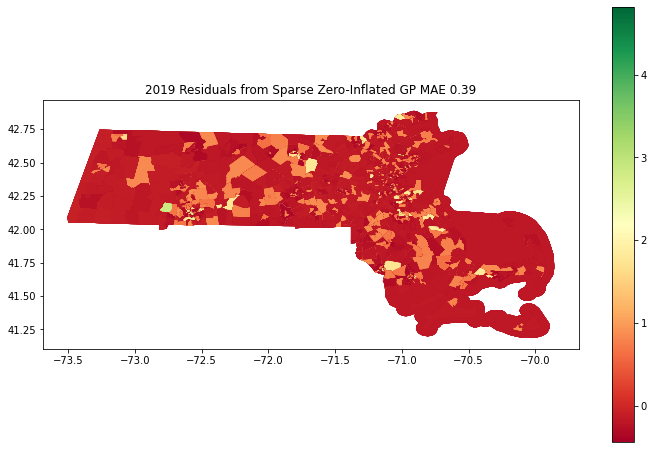

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
residual_gdf.plot(column='residuals', cmap='RdYlGn',ax=ax, legend=True,
                 vmin=-20, vmax=20)
plt.title(f'2019 Residuals from Sparse Zero-Inflated GP MAE {sg_MAE_2019:.2f}')


In [88]:
residual_gdf.residuals.min()

-10.929837603499301

In [92]:
comparisons = pd.read_csv(os.path.join(result_dir,'comparisons.csv'))
comparisons

,name,lat,lon,center,neighbors
0,N. Cambridge,42.3934,-71.1309,607,[581 582 583 606 607 608 631 632 633]
1,Jamaica Plain,42.3132,-71.1141,605,[579 580 581 604 605 606 629 630 631]
2,Springfield,42.1015,-72.5898,206,[191 192 193 205 206 207 219 220 221]
3,Pittsfield,42.4501,-73.2454,43,[29 30 31 42 43 44 56 57 58]
4,Brockton,42.0834,-71.0184,651,[625 626 627 650 651 652 678 679 680]
5,Lawrence,42.7070,-71.1631,612,[586 587 588 611 612 613 636 637 638]
6,Nantucket,41.2835,-70.0995,918,[911 917 918 919 928 929 930]
7,Falmouth,41.5532,-70.6086,848,[827 828 829 847 848 849 863 864 865]


Text(0.5, 1.05, 'Data for comparison locations, 2001-2019')

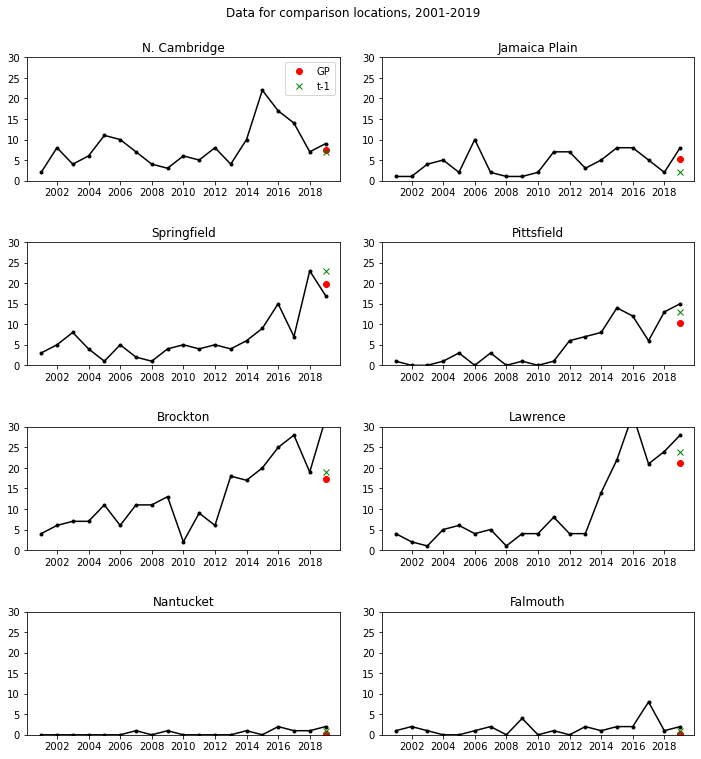

In [105]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for c, comparison in comparisons.iterrows():
    row = int(np.floor(c/2))
    col = c%2
    ax = axs[row, col]
    

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim([0,30])
    ax.set_title(comparison['name'])
        
    avg =  train_y_through_2019[train_y_through_2019['grid_squar']==comparison['center']].groupby('year').mean()['deaths']
    ax.plot(np.arange(2001, 2020), avg, 'k.-')
    
    ax.plot(2019, pred_2019_df.loc[comparison['center']],'ro', label='GP')
    ax.plot(2019,train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths'],'gx', label='t-1')
    if row==col==0:
        ax.legend()
fig.suptitle("Data for comparison locations, 2001-2019",y=1.05)

In [96]:
pred_2019_df

grid_squar
0      0.000336
1      0.000456
2      0.000477
3      0.000445
4      0.000415
         ...   
957    0.132581
958    0.021528
959    0.090112
960    0.000920
961    0.000781
Length: 962, dtype: float64

In [100]:
train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths']

,grid_squar,year,deaths
17202,848,2018,1.0


In [52]:
import scipy

In [53]:
scipy.__version__

'1.5.4'

In [25]:
m.savemodel?

In [28]:
m.savemodel('/cluster/home/kheuto01/testsavemodel.mod')

In [31]:
dir(m)

['ProbitExpectations',
 'X',
 'Xtrain',
 'Y',
 'Ytrain',
 'Zf',
 'Zg',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_begin_tf_mode',
 '_end_tf_mode',
 '_html_table_rows',
 '_kill_autoflow',
 '_name',
 '_needs_recompile',
 '_optimize_np',
 '_optimize_tf',
 '_parent',
 '_repr_html_',
 '_session',
 '_tf_mode',
 'build_likelihood',
 'build_predict',
 'build_prior',
 'build_prior_KL',
 'compile',
 'compute_log_likelihood',
 'compute_log_prior',
 'compute_prior_KL',
 'data_holders',
 'fixed',
 'get_feed_dict_keys',
 'get_free_state',
 'get_param_index',
 'get_parameter_dict',
 'get_samples_df',
 'highest_parent',
 'kernf',
 'kerng',
 'li

In [30]:
OnOffSVGP.update_feed_dict?

In [32]:
m.set_parameter_dict?

In [36]:
with open('/cluster/home/kheuto01/testsavemodel.mod','rb') as f:
    stuff = pickle.load(f)

In [34]:
import pickle

In [37]:
stuff

Name,values,prior,constraint
model.Zf,[[ 4.18669369e+01 -7.09463711e+01 5.60000000e+01 ... 5.90600000e-01 1.25000000e-01 0.00000000e+00] [ 4.21187998e+01 -7.16724964e+01 5.80000000e+01 ... 3.99900000e-01 0.00000000e+00 0.00000000e+00] [ 4.22878081e+01 -7.14697809e+01 5.90000000e+01 ... 3.66350000e-01 6.66666667e-02 0.00000000e+00] ... [ 4.24065607e+01 -7.10593394e+01 5.00000000e+01 ... 8.35800000e-01 7.17488789e-02 0.00000000e+00] [ 4.22837019e+01 -7.15916328e+01 1.80000000e+01 ... 4.98276314e-01 7.14285714e-02 0.00000000e+00] [ 4.19114347e+01 -7.10246769e+01 5.40000000e+01 ... 7.38200000e-01 7.69230769e-02 0.00000000e+00]],None,(none)
model.Zg,[[ 4.18669369e+01 -7.09463711e+01 5.60000000e+01 ... 5.90600000e-01 1.25000000e-01 0.00000000e+00] [ 4.21187998e+01 -7.16724964e+01 5.80000000e+01 ... 3.99900000e-01 0.00000000e+00 0.00000000e+00] [ 4.22878081e+01 -7.14697809e+01 5.90000000e+01 ... 3.66350000e-01 6.66666667e-02 0.00000000e+00] ... [ 4.24065607e+01 -7.10593394e+01 5.00000000e+01 ... 8.35800000e-01 7.17488789e-02 0.00000000e+00] [ 4.22837019e+01 -7.15916328e+01 1.80000000e+01 ... 4.98276314e-01 7.14285714e-02 0.00000000e+00] [ 4.19114347e+01 -7.10246769e+01 5.40000000e+01 ... 7.38200000e-01 7.69230769e-02 0.00000000e+00]],None,(none)
model.kernf.rbf_1.lengthscales,[1.],None,+ve
model.kernf.rbf_1.variance,[1.],None,+ve
model.kernf.rbf_2.lengthscales,[1.],None,+ve
model.kernf.rbf_2.variance,[1.],None,+ve
model.kernf.rbf_3.lengthscales,[1.],None,+ve
model.kernf.rbf_3.variance,[1.],None,+ve
model.kerng.rbf_1.lengthscales,[1.],None,+ve
model.kerng.rbf_1.variance,[1.],None,+ve
